In [1]:
from __future__ import division, print_function
import sys, os, glob, time, warnings, gc
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table, vstack, hstack, join
import fitsio
# from astropy.io import fits

from scipy import stats
from IPython.display import Image

sys.path.append(os.path.expanduser('~/git/Python/user_modules/'))
from match_coord import match_coord

import select_desi_targets

In [2]:
params = {'legend.fontsize': 'large',
          'axes.labelsize': 'large',
          'axes.titlesize': 'large',
          'xtick.labelsize': 'large',
          'ytick.labelsize': 'large',
          'figure.facecolor': 'w'}
plt.rcParams.update(params)

In [3]:
ramin, ramax, decmin, decmax = 147.8+1.2, 152.5-1.2, -0.1+1.2, 4.5-1.2
nmad = lambda x: 1.4826*np.nanmedian(np.abs(x-np.nanmedian(x)))

In [4]:
subs = Table(fitsio.read('/global/cfs/cdirs/desi/users/rongpu/data/deep_field_subsets/catalogs/cosmos_subsets_rongpu_dr10.fits'))
print(len(subs))

min_nobs = 1
mask = (subs['ngood_g']>=min_nobs) & (subs['ngood_r']>=min_nobs) & (subs['ngood_z']>=min_nobs)
subs = subs[mask]
print(len(subs))

# Remove objects with large sky residuals
for band in ['g', 'r', 'z']:
    subs[band+'_sky'] = (subs['apflux_blobresid_'+band][:, -1]-subs['apflux_blobresid_'+band][:, -2]) / (np.pi*7**2-np.pi*5**2)
mask = (subs['g_sky']>-0.002*2) & (subs['g_sky']<0.002*2)
print(np.sum(mask)/len(mask))
mask &= (subs['r_sky']>-0.003*2) & (subs['r_sky']<0.003*2)
print(np.sum(mask)/len(mask))
mask &= (subs['z_sky']>-0.006*2) & (subs['z_sky']<0.006*2)
print(np.sum(mask)/len(mask))
subs = subs[mask]
print(len(subs))

# Only keep isolated sources
mask = (subs['fracflux_g']>-0.01) & (subs['fracflux_g']<0.01)
print(np.sum(mask)/len(mask))
mask &= (subs['fracflux_r']>-0.01) & (subs['fracflux_r']<0.01)
print(np.sum(mask)/len(mask))
mask &= (subs['fracflux_z']>-0.01) & (subs['fracflux_z']<0.01)
print(np.sum(mask)/len(mask))
subs = subs[mask]
print(len(subs))

mask = np.full(len(subs), True)
for band in ['g', 'r', 'z']:
    mask &= subs['flux_ivar_'+band]>0
subs = subs[mask]
print(len(subs))

# tmp = Table()
# tmp['sub'], tmp['count'] = np.unique(subs['sub'], return_counts=True)
# tmp

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    subs['gmag'] = 22.5 - 2.5*np.log10(subs['flux_g']) - 3.214 * subs['ebv']
    subs['rmag'] = 22.5 - 2.5*np.log10(subs['flux_r']) - 2.165 * subs['ebv']
    subs['zmag'] = 22.5 - 2.5*np.log10(subs['flux_z']) - 1.211 * subs['ebv']
    subs['w1mag'] = 22.5 - 2.5*np.log10(subs['flux_w1']) - 0.184 * subs['ebv']
    subs['w2mag'] = 22.5 - 2.5*np.log10(subs['flux_w2']) - 0.113 * subs['ebv']
    subs['gmagerr'] = 1/np.sqrt(subs['flux_ivar_g'])/(subs['flux_g'])
    subs['rmagerr'] = 1/np.sqrt(subs['flux_ivar_r'])/(subs['flux_r'])
    subs['zmagerr'] = 1/np.sqrt(subs['flux_ivar_z'])/(subs['flux_z'])
    subs['w1magerr'] = 1/np.sqrt(subs['flux_ivar_w1'])/(subs['flux_w1'])
    subs['w2magerr'] = 1/np.sqrt(subs['flux_ivar_w2'])/(subs['flux_w2'])
    subs['gfibermag'] = 22.5 - 2.5*np.log10(subs['fiberflux_g']) - 3.214 * subs['ebv']
    subs['rfibermag'] = 22.5 - 2.5*np.log10(subs['fiberflux_r']) - 2.165 * subs['ebv']
    subs['zfibermag'] = 22.5 - 2.5*np.log10(subs['fiberflux_z']) - 1.211 * subs['ebv']

3183343
2752104
0.9313085551999488
0.882942287064733
0.782445358169604
2153371
0.6551885392716815
0.6204875982819495
0.5836119275312986
1256733
1256730


In [14]:
subset_pairs = np.arange(10).reshape(5, 2)
np.random.seed(512)
subset_pairs = np.random.choice(10, size=10, replace=False).reshape(5, 2)
print(subset_pairs)

ref_subset = 'dr9_ccds'

[[4 6]
 [7 9]
 [5 0]
 [8 2]
 [1 3]]


In [15]:
# Use a different subset to select an unbiased ELG sample
mask = subs['sub']==ref_subset
sub3 = subs[mask].copy()

################ ONLY USE g>22.5 ELGs ################
mask = sub3['gmag']>22.5
sub3 = sub3[mask]
print(len(sub3))

sub3_elglop, sub3_elgvlo = select_desi_targets.select_elgs(sub3)

97994


In [16]:
sub1_stack, sub2_stack = [], []

for subset_pair in subset_pairs:

    subset_pair = subset_pairs[0]

    mask = subs['sub']=='sub-'+str(subset_pair[0])
    sub1 = subs[mask].copy()
    print(len(sub1))

    mask = subs['sub']=='sub-'+str(subset_pair[1])
    sub2 = subs[mask].copy()
    print(len(sub2))

    idx1, idx2, d2d, d_ra, d_dec = match_coord(sub1['ra'], sub1['dec'], sub2['ra'], sub2['dec'], search_radius=0.5, plot_q=False, verbose=False)
    sub1 = sub1[idx1]
    sub2 = sub2[idx2]

    idx1, idx2, d2d, d_ra, d_dec = match_coord(sub3['ra'], sub3['dec'], sub1['ra'], sub1['dec'], search_radius=0.5, plot_q=False, verbose=False)
    elglop = np.in1d(np.arange(len(sub1)), idx2[sub3_elglop[idx1]])
    elgvlo = np.in1d(np.arange(len(sub1)), idx2[sub3_elgvlo[idx1]])
    print(np.sum(elglop), np.sum(elgvlo))

    mask0 = elglop.copy()
    sub1 = sub1[mask0]
    sub2 = sub2[mask0]

    sub1_stack.append(sub1)
    sub2_stack.append(sub2)
    
sub1 = vstack(sub1_stack)
sub2 = vstack(sub2_stack)

99783
114978
1130 345
99783
114978
1130 345
99783
114978
1130 345
99783
114978
1130 345
99783
114978
1130 345


fluxes


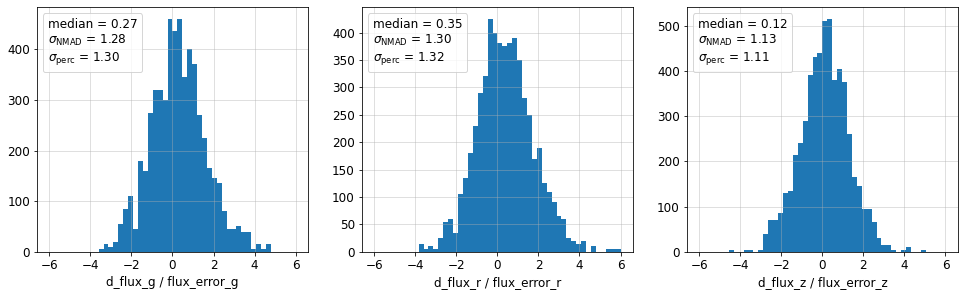

fiberflux


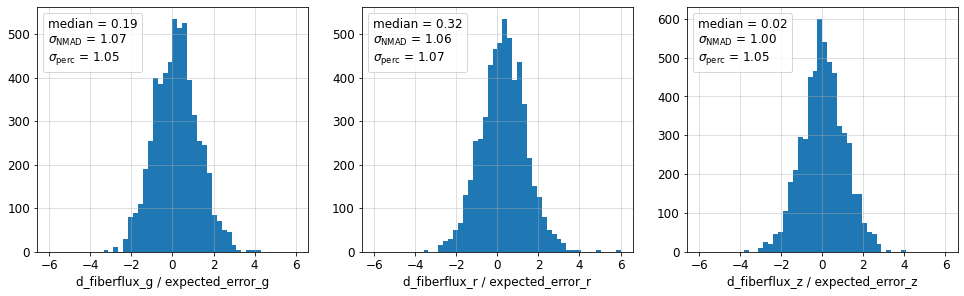

colors


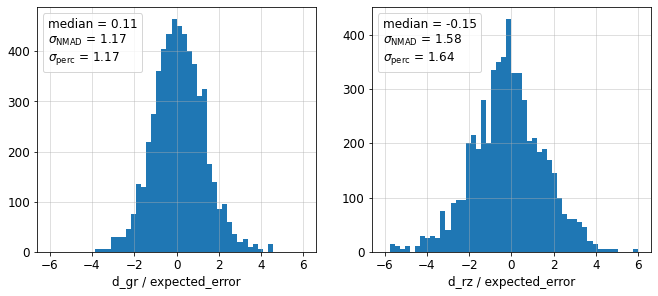

In [17]:
print('fluxes')
fig, axes = plt.subplots(1, 3, figsize=(16.5, 4.5))
for index, band in enumerate(['g', 'r', 'z']):
    ax = axes[index]
    v = (sub2['flux_'+band]-sub1['flux_'+band]) / np.sqrt(1/sub2['flux_ivar_'+band]+1/sub1['flux_ivar_'+band])
    legend_text = 'median = {:.2f}\n'.format(np.nanmedian(v))+\
                 '$\sigma_\mathrm{NMAD}$'+' = {:.2f}\n'.format(nmad(v))+\
                 '$\sigma_\mathrm{perc}$'+' = {:.2f}'.format((np.nanpercentile(v, 84.1)-np.nanpercentile(v, 15.9))/2)
    ax.hist(v, 50, range=(-6, 6), label=legend_text)
    ax.set_xlabel('d_flux_{} / flux_error_{}'.format(band, band, band))
    ax.legend(loc='upper left', handlelength=0, handletextpad=0)
    ax.grid(alpha=0.5)
plt.show()

print('fiberflux')
fig, axes = plt.subplots(1, 3, figsize=(16.5, 4.5))
for index, band in enumerate(['g', 'r', 'z']):
    ax = axes[index]
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        v = (sub2['fiberflux_'+band]-sub1['fiberflux_'+band]) / np.sqrt((sub2['fiberflux_'+band]/sub2['flux_'+band])**2/sub2['flux_ivar_'+band]+(sub1['fiberflux_'+band]/sub1['flux_'+band])**2/sub1['flux_ivar_'+band])
    legend_text = 'median = {:.2f}\n'.format(np.nanmedian(v))+\
                 '$\sigma_\mathrm{NMAD}$'+' = {:.2f}\n'.format(nmad(v))+\
                 '$\sigma_\mathrm{perc}$'+' = {:.2f}'.format((np.nanpercentile(v, 84.1)-np.nanpercentile(v, 15.9))/2)
    ax.hist(v, 50, range=(-6, 6), label=legend_text)
    ax.set_xlabel('d_fiberflux_{} / expected_error_{}'.format(band, band, band))
    ax.legend(loc='upper left', handlelength=0, handletextpad=0)
    ax.grid(alpha=0.5)
plt.show()

print('colors')
fig, axes = plt.subplots(1, 2, figsize=(11., 4.5))
for index, color in enumerate([['g', 'r'], ['r', 'z']]):
    ax = axes[index]
    band1, band2 = color
    v = ((sub2[band1+'mag']-sub2[band2+'mag'])-(sub1[band1+'mag']-sub1[band2+'mag'])) / \
    np.sqrt(sub2[band1+'magerr']**2+sub2[band1+'magerr']**2+sub1[band1+'magerr']**2+sub1[band1+'magerr']**2)
    legend_text = 'median = {:.2f}\n'.format(np.nanmedian(v))+\
                 '$\sigma_\mathrm{NMAD}$'+' = {:.2f}\n'.format(nmad(v))+\
                 '$\sigma_\mathrm{perc}$'+' = {:.2f}'.format((np.nanpercentile(v, 84.1)-np.nanpercentile(v, 15.9))/2)
    ax.hist(v, 50, range=(-6, 6), label=legend_text)
    ax.set_xlabel('d_{}{} / expected_error'.format(band1, band2, band1, band2))
    ax.legend(loc='upper left', handlelength=0, handletextpad=0)
    ax.grid(alpha=0.5)
plt.show()

In [21]:
band1 = 'g'
band2 = 'r'
band3 = 'z'
x1 = (sub2['flux_'+band1]-sub1['flux_'+band1]) / np.sqrt(1/sub2['flux_ivar_'+band1]+1/sub1['flux_ivar_'+band1])
x2 = (sub2['flux_'+band2]-sub1['flux_'+band2]) / np.sqrt(1/sub2['flux_ivar_'+band2]+1/sub1['flux_ivar_'+band2])
x3 = (sub2['flux_'+band3]-sub1['flux_'+band3]) / np.sqrt(1/sub2['flux_ivar_'+band3]+1/sub1['flux_ivar_'+band3])
x1_fiber = (sub2['fiberflux_'+band1]-sub1['fiberflux_'+band1]) / np.sqrt((sub1['fiberflux_'+band1]/sub1['flux_'+band1])**2/sub2['flux_ivar_'+band1]+(sub1['fiberflux_'+band1]/sub1['flux_'+band1])**2/sub1['flux_ivar_'+band1])

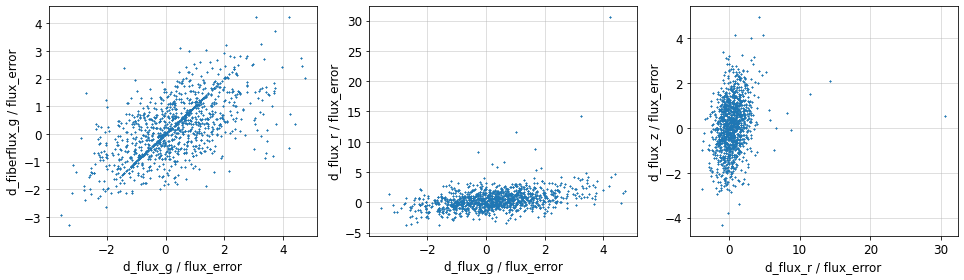

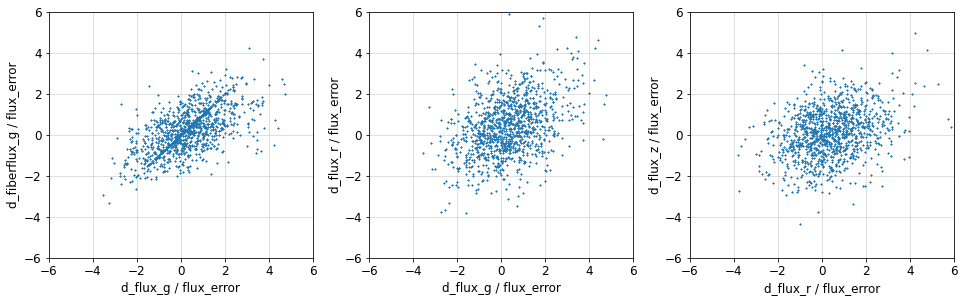

array([[ 1.77394738,  0.73528094,  0.52990701,  0.847554  ],
       [ 0.73528094,  1.88517582,  0.48621208, -0.1686987 ],
       [ 0.52990701,  0.48621208,  1.41223556, -0.07859589],
       [ 0.847554  , -0.1686987 , -0.07859589,  1.1093493 ]])

In [28]:
mask = np.full(len(x1), True)
fig, axes = plt.subplots(1, 3, figsize=(13.5, 4.))
axes[0].plot(x1[mask], x1_fiber[mask], '.', ms=1)
axes[0].grid(alpha=0.5)
axes[0].set_xlabel('d_flux_g / flux_error')
axes[0].set_ylabel('d_fiberflux_g / flux_error')
axes[1].plot(x1[mask], x2[mask], '.', ms=1)
axes[1].grid(alpha=0.5)
axes[1].set_xlabel('d_flux_g / flux_error')
axes[1].set_ylabel('d_flux_r / flux_error')
axes[2].plot(x2[mask], x3[mask], '.', ms=1)
axes[2].grid(alpha=0.5)
axes[2].set_xlabel('d_flux_r / flux_error')
axes[2].set_ylabel('d_flux_z / flux_error')
plt.tight_layout()
plt.show()

mask = (np.abs(x1)<6) & (np.abs(x1_fiber)<6) & (np.abs(x2)<6) & (np.abs(x3)<6)
fig, axes = plt.subplots(1, 3, figsize=(13.5, 4.3))
axes[0].plot(x1[mask], x1_fiber[mask], '.', ms=1)
axes[0].grid(alpha=0.5)
axes[0].set_xlabel('d_flux_g / flux_error')
axes[0].set_ylabel('d_fiberflux_g / flux_error')
axes[0].axis([-6, 6, -6, 6])
axes[1].plot(x1[mask], x2[mask], '.', ms=1)
axes[1].grid(alpha=0.5)
axes[1].set_xlabel('d_flux_g / flux_error')
axes[1].set_ylabel('d_flux_r / flux_error')
axes[1].axis([-6, 6, -6, 6])
axes[2].plot(x2[mask], x3[mask], '.', ms=1)
axes[2].grid(alpha=0.5)
axes[2].set_xlabel('d_flux_r / flux_error')
axes[2].set_ylabel('d_flux_z / flux_error')
axes[2].axis([-6, 6, -6, 6])
plt.tight_layout()
plt.show()

np.cov([x1[mask], x2[mask], x3[mask], x1_fiber[mask]])

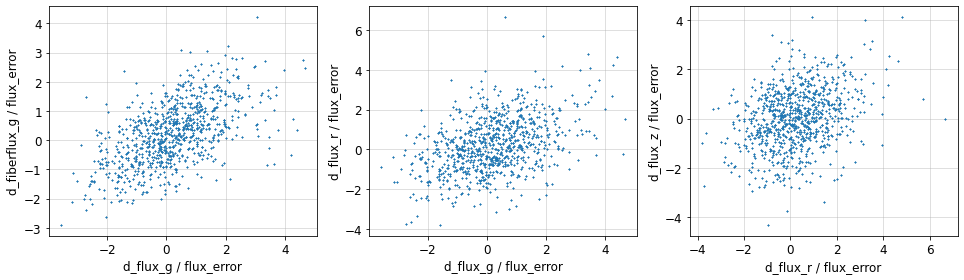

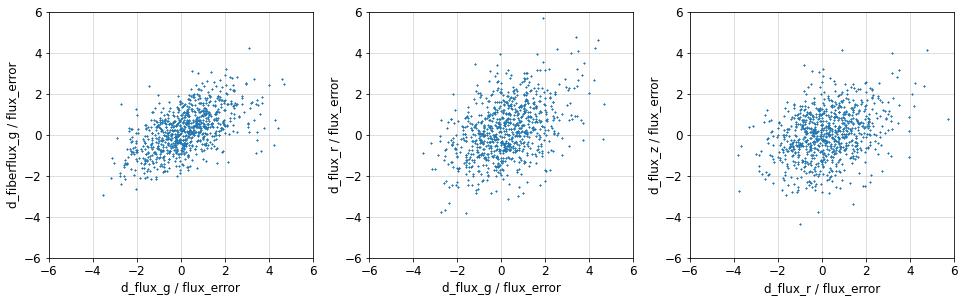

array([[ 1.82099847,  0.78240495,  0.54215921,  0.80606189],
       [ 0.78240495,  1.85240497,  0.5222661 , -0.19157878],
       [ 0.54215921,  0.5222661 ,  1.46269049, -0.13327667],
       [ 0.80606189, -0.19157878, -0.13327667,  1.11771543]])

In [29]:
mask = sub1['type']!='PSF'
fig, axes = plt.subplots(1, 3, figsize=(13.5, 4.))
axes[0].plot(x1[mask], x1_fiber[mask], '.', ms=1)
axes[0].grid(alpha=0.5)
axes[0].set_xlabel('d_flux_g / flux_error')
axes[0].set_ylabel('d_fiberflux_g / flux_error')
axes[1].plot(x1[mask], x2[mask], '.', ms=1)
axes[1].grid(alpha=0.5)
axes[1].set_xlabel('d_flux_g / flux_error')
axes[1].set_ylabel('d_flux_r / flux_error')
axes[2].plot(x2[mask], x3[mask], '.', ms=1)
axes[2].grid(alpha=0.5)
axes[2].set_xlabel('d_flux_r / flux_error')
axes[2].set_ylabel('d_flux_z / flux_error')
plt.tight_layout()
plt.show()

mask = sub1['type']!='PSF'
mask &= (np.abs(x1)<6) & (np.abs(x1_fiber)<6) & (np.abs(x2)<6) & (np.abs(x3)<6)
fig, axes = plt.subplots(1, 3, figsize=(13.5, 4.3))
axes[0].plot(x1[mask], x1_fiber[mask], '.', ms=1)
axes[0].grid(alpha=0.5)
axes[0].set_xlabel('d_flux_g / flux_error')
axes[0].set_ylabel('d_fiberflux_g / flux_error')
axes[0].axis([-6, 6, -6, 6])
axes[1].plot(x1[mask], x2[mask], '.', ms=1)
axes[1].grid(alpha=0.5)
axes[1].set_xlabel('d_flux_g / flux_error')
axes[1].set_ylabel('d_flux_r / flux_error')
axes[1].axis([-6, 6, -6, 6])
axes[2].plot(x2[mask], x3[mask], '.', ms=1)
axes[2].grid(alpha=0.5)
axes[2].set_xlabel('d_flux_r / flux_error')
axes[2].set_ylabel('d_flux_z / flux_error')
axes[2].axis([-6, 6, -6, 6])
plt.tight_layout()
plt.show()

np.cov([x1[mask], x2[mask], x3[mask], x1_fiber[mask]])